In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../practice"))
from scipy import stats
from sklearn.metrics import mean_squared_error

['practice.ipynb', 'predic_clm.ipynb', 'test.csv', 'loan_test.csv', 'InsNova_data_2023_train.csv', '.ipynb_checkpoints', 'clean_weather.csv', 'predic_claimcst.ipynb', 'loanamountprediction-zero-inflated-target-values.ipynb', 'loan_train.csv', 'predic_numclaims.ipynb', 'Proj_prac.ipynb', 'train.csv', 'InsNova_data_2023_vh.csv', 'house-price-regression-with-lightgbm.ipynb']


In [2]:
df_train = pd.read_csv("InsNova_data_2023_train.csv", index_col='id')
df_test = pd.read_csv("InsNova_data_2023_vh.csv", index_col='id')

In [3]:
df_train.sample(3)

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
id,,,,,,,,,,,,,,,,,,,,,
3829,1.77,0.252302,SEDAN,2,F,B,3,petrol,190,94.0,...,S,1,weekday,6am - 12pm,6,669.434922,0.0,0,0,0.00000
11062,1.47,0.401474,SEDAN,3,M,E,6,petrol,155,48.0,...,M,0,weekday,6am - 12pm,6,651.865518,0.0,0,0,0.00000
1219,2.07,0.554703,STNWG,3,M,B,4,petrol,187,78.0,...,M,0,weekday,12am - 6 am,12,644.221298,0.0,1,1,19240.98103


In [4]:
df_test.sample(3)

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind
id,,,,,,,,,,,,,,,,,,
21860,4.91,0.792905,STNWG,1,F,E,4,hybrid,112,62,silver,M,1,weekday,6am - 12pm,12,644.732811,0
7945,0.79,0.762253,TRUCK,3,M,E,6,dissel,252,50,red,S,1,weekday,12am - 6 am,12,641.132757,0
1158,1.90,0.537115,HBACK,1,F,C,5,petrol,124,54,red,M,1,weekday,12pm - 6pm,12,661.670960,0


In [5]:
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (22619, 21), test: (22620, 18)


So we have ~1500 records with 80 features. Lets look at some basic statistics of the current numerical features.

In [6]:
df_train.claimcst0.max()

57895.58456

In [7]:
pd.options.display.max_columns = None # Show all cols
df_train.describe()

,veh_value,exposure,veh_age,agecat,max_power,driving_history_score,e_bill,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
count,22619.000000,22619.000000,22619.000000,22619.000000,22619.000000,22619.000000,22619.00000,22619.000000,22619.000000,22619.000000,22619.000000,22619.000000,22619.000000
mean,1.868948,0.433038,2.667492,3.481675,152.447765,70.868341,0.63681,10.493833,649.875077,0.117114,0.068173,0.073124,163.048084
std,1.278588,0.272899,1.070555,1.420252,51.834156,19.083318,0.48093,2.601685,10.515364,0.321563,0.252048,0.280142,1271.955238
min,0.000000,0.001754,1.000000,1.000000,60.000000,1.000000,0.00000,6.000000,607.797435,0.000000,0.000000,0.000000,0.000000
25%,1.070000,0.203696,2.000000,2.000000,115.000000,58.000000,0.00000,6.000000,643.134748,0.000000,0.000000,0.000000,0.000000
50%,1.570000,0.384313,3.000000,3.000000,144.000000,72.000000,1.00000,12.000000,647.180197,0.000000,0.000000,0.000000,0.000000
75%,2.260000,0.643316,4.000000,5.000000,180.000000,86.000000,1.00000,12.000000,654.069205,0.000000,0.000000,0.000000,0.000000
max,24.510000,0.999378,4.000000,6.000000,409.000000,99.000000,1.00000,12.000000,790.360253,1.000000,1.000000,3.000000,57895.584560


In [8]:
df_na = (df_train.isnull().sum() / len(df_train)) * 100

df_na[df_na == 0].index

Index(['veh_value', 'exposure', 'veh_body', 'veh_age', 'gender', 'area',
       'agecat', 'engine_type', 'max_power', 'driving_history_score',
       'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven',
       'time_driven', 'trm_len', 'credit_score', 'high_education_ind', 'clm',
       'numclaims', 'claimcst0'],
      dtype='object')

In [9]:
df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(10)

,Missing Ratio


In [10]:
# fig, ax = plt.subplots(1,2)
# width, height = fig.get_size_inches()
# fig.set_size_inches(width*2, height)
# sns.distplot(df_train['claimcst0'], ax=ax[0], fit=norm)
# sns.distplot(np.log(df_train[('claimcst0')]+1), ax=ax[1], fit= norm)

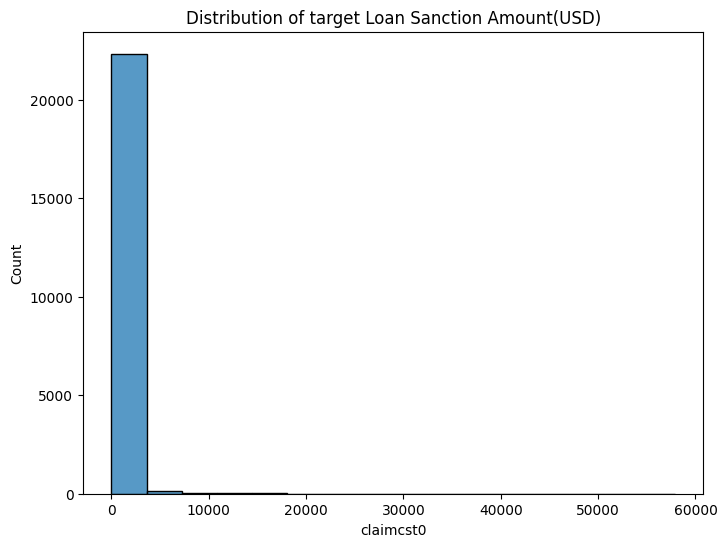

In [11]:
plt.figure(figsize=(8, 6))

target = (df_train['claimcst0'])

sns.histplot(x=target)

plt.title('Distribution of target Loan Sanction Amount(USD)')
plt.show()

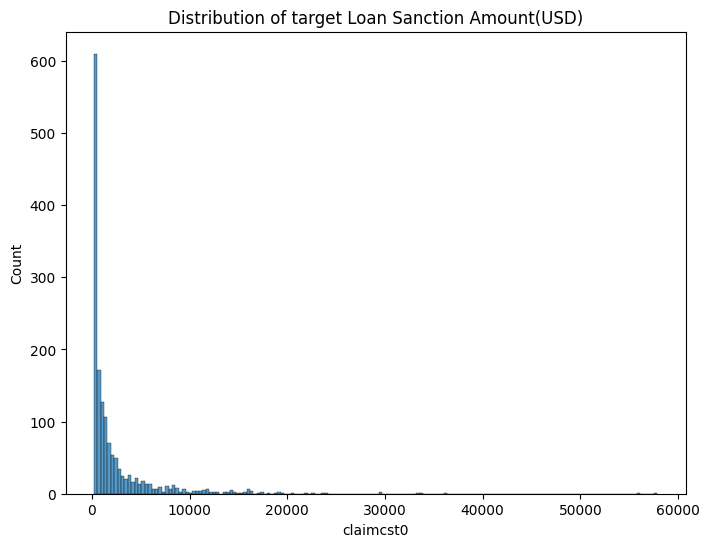

In [12]:
plt.figure(figsize=(8, 6))

target = (df_train['claimcst0'])

sns.histplot(x=target[target>0])

plt.title('Distribution of target Loan Sanction Amount(USD)')
plt.show()

In [13]:
print(f"The target has a skewness of {target.skew()}")
print(f"The target has a peakedness of {target.kurtosis()}")

The target has a skewness of 18.049550259459473
The target has a peakedness of 522.6760082665686


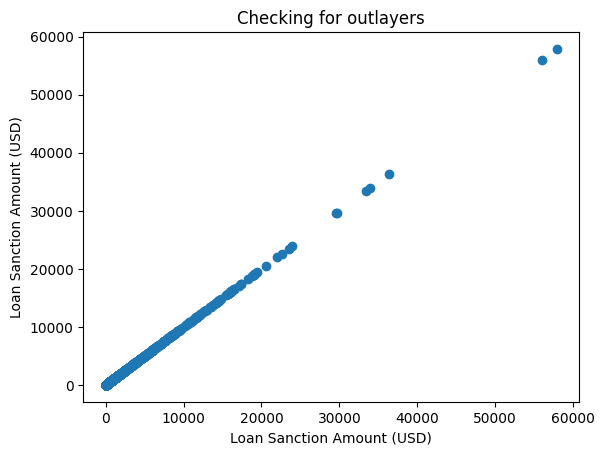

In [14]:
plt.scatter(target, target)

plt.xlabel('Loan Sanction Amount (USD)')
plt.ylabel('Loan Sanction Amount (USD)')
plt.title("Checking for outlayers")

plt.show()

Finding which transformation fits our target distribution the best


/tmp/ipykernel_80/2542756570.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_without_zero, fit=stats.johnsonsu)
/tmp/ipykernel_80/2542756570.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_without_zero, fit=stats.lognorm)
/tmp/ipykernel_80/2542756570.py:21: UserWarning: 


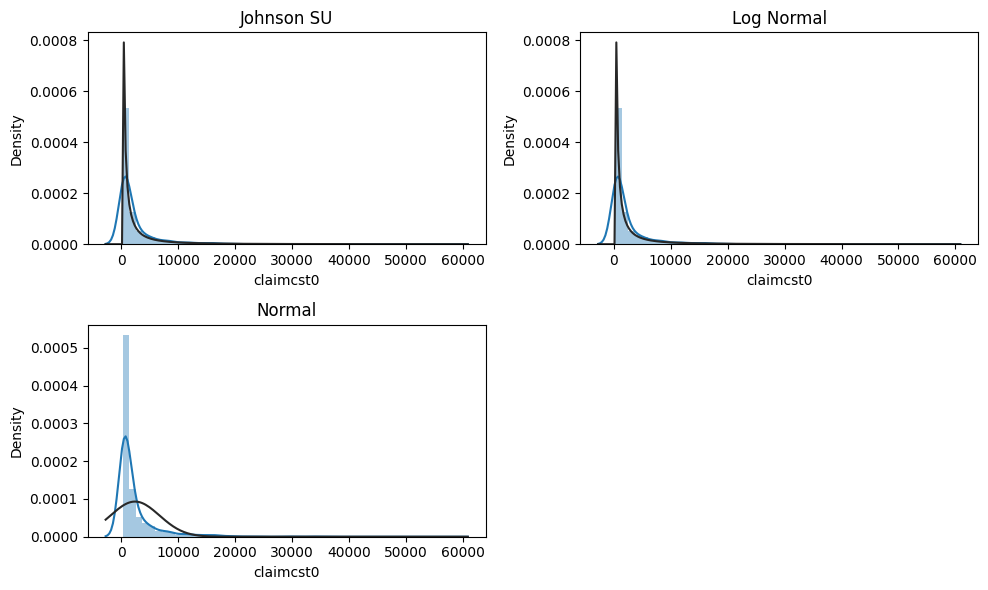

In [15]:

target_without_zero = target[target > 0]

print('Finding which transformation fits our target distribution the best')

plt.figure(figsize=(10, 6))

# Johnson Distribution
plt.subplot(2, 2, 1);
sns.distplot(target_without_zero, fit=stats.johnsonsu)
plt.title('Johnson SU')

# Log Normal Distribution
plt.subplot(2, 2, 2)
sns.distplot(target_without_zero, fit=stats.lognorm)
plt.title("Log Normal")

# Normal Distribution
plt.subplot(2, 2, 3)
sns.distplot(target_without_zero, fit=stats.norm)
plt.title("Normal")

plt.tight_layout()

/tmp/ipykernel_80/2966495358.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x= transformed_data)


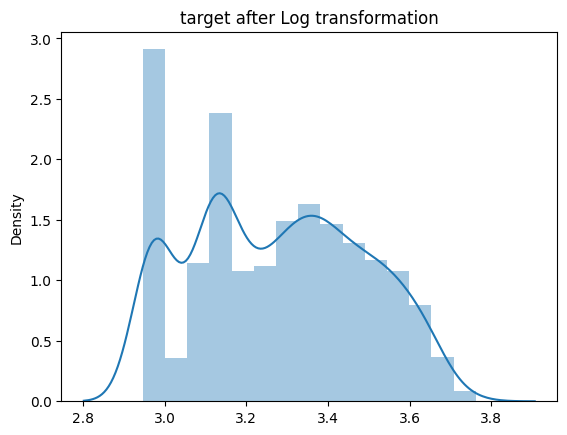

In [16]:
transformed_data, lam = stats.boxcox(target_without_zero)

sns.distplot(x= transformed_data)

plt.title("target after Log transformation")
plt.show()

In [20]:
type(transformed_data), transformed_data.shape

(numpy.ndarray, (1542,))

/tmp/ipykernel_80/930618230.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = target_transformed1)


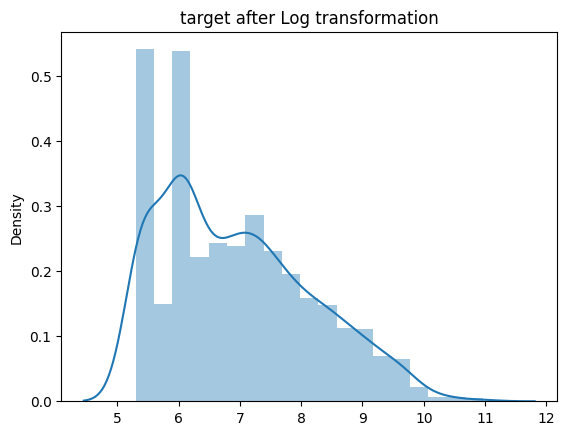

In [17]:
target_transformed1 = np.log(target_without_zero)

sns.distplot(x = target_transformed1)

plt.title("target after Log transformation")
plt.show()

In [21]:
type(target_transformed1), target_transformed1.shape

(pandas.core.series.Series, (1542,))

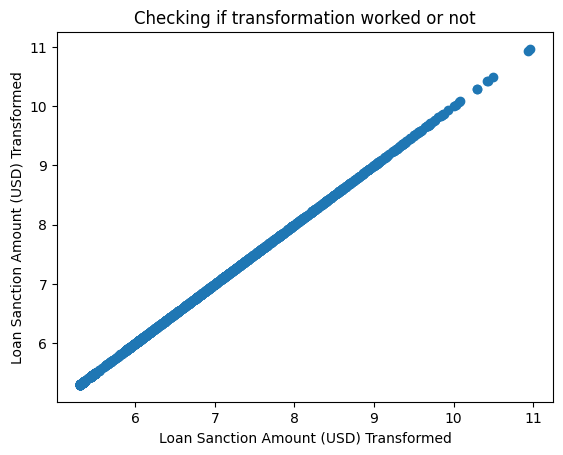

In [311]:
plt.scatter(target_transformed1, target_transformed1)
plt.xlabel('Loan Sanction Amount (USD) Transformed')
plt.ylabel('Loan Sanction Amount (USD) Transformed')
plt.title("Checking if transformation worked or not")
plt.show()

In [22]:
print(f"The target has a skewness of {pd.Series(target_transformed1).skew()} after transformation")
print(f"The target has a peakedness of {pd.Series(target_transformed1).kurtosis()} after transformation")

The target has a skewness of 0.5798923735766323 after transformation
The target has a peakedness of -0.49427042943852895 after transformation


In [23]:
print(f"The target has a skewness of {pd.Series(transformed_data).skew()} after transformation")
print(f"The target has a peakedness of {pd.Series(transformed_data).kurtosis()} after transformation")

The target has a skewness of 0.10926891500566203 after transformation
The target has a peakedness of -1.0619727283709346 after transformation


In [24]:
df_train = df_train.drop(['clm', 'numclaims'], axis=1)

In [25]:
# def fill_missing(df, cols, val):
#     """ Fill with the supplied val """
#     for col in cols:
#         df[col] = df[col].fillna(val)

# def fill_missing_with_mode(df, cols):
#     """ Fill with the mode """
#     for col in cols:
#         df[col] = df[col].fillna(df[col].mode()[0])
        
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

In [26]:
loglist = ['max_power', 'driving_history_score']

df_train = addlogs(df_train, loglist)

In [27]:
df_train.sample(3)

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,claimcst0,max_power_log,driving_history_score_log
id,,,,,,,,,,,,,,,,,,,,,
13117,0.46,0.054124,HBACK,4,M,A,4,petrol,101,82.0,white,M,0,weekday,6am - 12pm,6,659.361799,0.0,0.0,4.625071,4.418961
11378,1.38,0.659200,COUPE,3,F,B,2,petrol,263,93.0,gray,S,1,weekday,12pm - 6pm,12,670.600108,0.0,0.0,5.575987,4.543401
17882,3.00,0.562261,SEDAN,2,F,C,3,electric,176,72.0,gray,S,1,weekday,12pm - 6pm,12,664.967104,0.0,0.0,5.176206,4.290596


In [28]:
df_train["claimcst0"] = np.log1p(df_train["claimcst0"])

In [29]:
df_train["high_education_ind"] = (df_train["high_education_ind"]).astype(int)

In [32]:
df_train['veh_age'] = df_train['veh_age'].apply(str)
df_train['agecat'] = df_train['agecat'].astype(str)
df_train['e_bill'] = df_train['e_bill'].astype(str)
df_train['trm_len'] = df_train['trm_len'].astype(str)
df_train['high_education_ind'] = df_train['high_education_ind'].astype(str)

In [33]:
set(df_train.columns) - set(df_test.columns)

{'claimcst0', 'driving_history_score_log', 'max_power_log'}

In [34]:
def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # Add a missing column in test set with default value equal tao 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return in_test

def dummy_encode(in_df_train, in_df_test):
    df_train = in_df_train
    df_test = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = fix_missing_cols(df_train, df_test)
    return df_train, df_test


In [35]:
df_train.shape, df_test.shape

((22619, 21), (22620, 18))

In [38]:
df_train, df_test = dummy_encode(df_train, df_test)
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind']
Shape train: (22619, 66), test: (22620, 66)


In [40]:
y = pd.Series(transformed_data)
y.sample(3)

1186    3.398051
327     3.171297
1205    3.355871
dtype: float64

In [41]:
y = df_train["claimcst0"]
y.sample(3)

id
11819    0.000000
3958     0.000000
18202    5.984863
Name: claimcst0, dtype: float64

In [42]:
df_train.drop(["claimcst0"], axis=1, inplace=True)
# The fix missing cols above will have added the target column to the test data frame, so this is a workaround to remove it
df_test.drop(["claimcst0"], axis=1, inplace=True) 

In [43]:
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (22619, 65), test: (22620, 65)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split( df_train, y, test_size=0.25, random_state=42)

In [45]:
X_train.columns

Index(['veh_value', 'exposure', 'max_power', 'driving_history_score',
       'credit_score', 'max_power_log', 'driving_history_score_log',
       'veh_body_BUS', 'veh_body_CONVT', 'veh_body_COUPE', 'veh_body_HBACK',
       'veh_body_HDTOP', 'veh_body_MCARA', 'veh_body_MIBUS', 'veh_body_PANVN',
       'veh_body_RDSTR', 'veh_body_SEDAN', 'veh_body_STNWG', 'veh_body_TRUCK',
       'veh_body_UTE', 'veh_age_1', 'veh_age_2', 'veh_age_3', 'veh_age_4',
       'gender_F', 'gender_M', 'area_A', 'area_B', 'area_C', 'area_D',
       'area_E', 'area_F', 'agecat_1', 'agecat_2', 'agecat_3', 'agecat_4',
       'agecat_5', 'agecat_6', 'engine_type_dissel', 'engine_type_electric',
       'engine_type_hybrid', 'engine_type_petrol', 'veh_color_black',
       'veh_color_blue', 'veh_color_brown', 'veh_color_gray',
       'veh_color_green', 'veh_color_red', 'veh_color_silver',
       'veh_color_white', 'veh_color_yellow', 'marital_status_M',
       'marital_status_S', 'e_bill_0', 'e_bill_1',
       'time_of_

In [46]:
X_test.columns

Index(['veh_value', 'exposure', 'max_power', 'driving_history_score',
       'credit_score', 'max_power_log', 'driving_history_score_log',
       'veh_body_BUS', 'veh_body_CONVT', 'veh_body_COUPE', 'veh_body_HBACK',
       'veh_body_HDTOP', 'veh_body_MCARA', 'veh_body_MIBUS', 'veh_body_PANVN',
       'veh_body_RDSTR', 'veh_body_SEDAN', 'veh_body_STNWG', 'veh_body_TRUCK',
       'veh_body_UTE', 'veh_age_1', 'veh_age_2', 'veh_age_3', 'veh_age_4',
       'gender_F', 'gender_M', 'area_A', 'area_B', 'area_C', 'area_D',
       'area_E', 'area_F', 'agecat_1', 'agecat_2', 'agecat_3', 'agecat_4',
       'agecat_5', 'agecat_6', 'engine_type_dissel', 'engine_type_electric',
       'engine_type_hybrid', 'engine_type_petrol', 'veh_color_black',
       'veh_color_blue', 'veh_color_brown', 'veh_color_gray',
       'veh_color_green', 'veh_color_red', 'veh_color_silver',
       'veh_color_white', 'veh_color_yellow', 'marital_status_M',
       'marital_status_S', 'e_bill_0', 'e_bill_1',
       'time_of_

In [47]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((16964, 65), (5655, 65), (16964,), (5655,))

In [48]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    # "max_depth": 8,
    "num_leaves": 50,  
    # "max_bin": 512
    'early_stopping_round': 10000
}

In [49]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

In [50]:
model = lgb.train(hyper_params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round=100000)

In [51]:
Y_pred = model.predict(X_test)

MSE: 3.23
RMSE: 1.80


/tmp/ipykernel_80/2254156514.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(x_ax[:100], Y_test[:100], label="original")


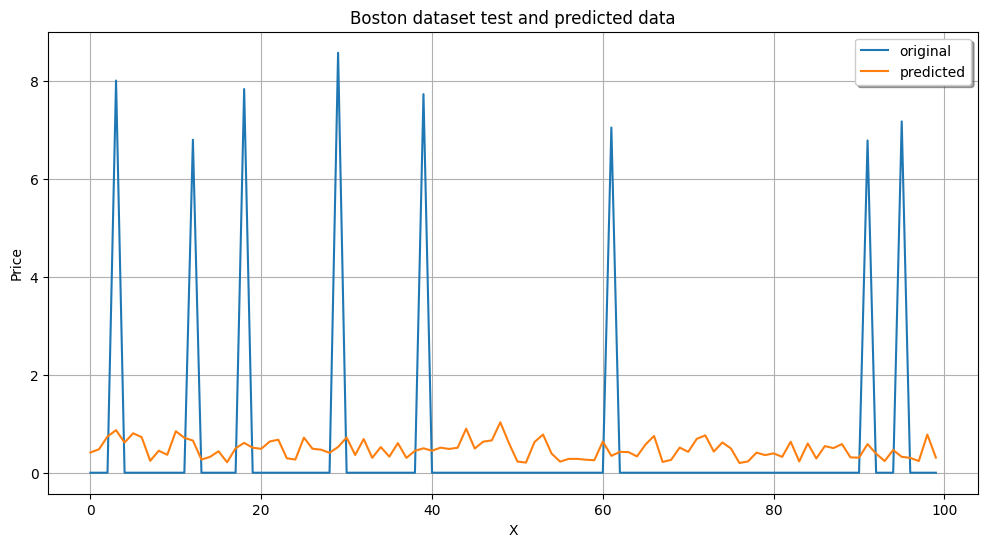

In [52]:
# accuracy check
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

# visualizing in a plot
x_ax = range(len(Y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax[:100], Y_test[:100], label="original")
plt.plot(x_ax[:100], Y_pred[:100], label="predicted")
plt.title("Boston dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  
 